In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
import sys
plt.style.use("~/evanstyle.mplstyle")

sys.path.append("../CombinedData/")
import Dataset

In [4]:
topdir = "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run7/"
datasets = ["cosmics-endofrun/", "ds01/","ds02/","ds03/", "ds04/","ds05/","ds06/","ds07/",\
        "ds08/","ds09/","ds10/","ds11/","filling/", "room-temp-dark-noise/"]

ds_single = "ds10/"
config = "../configs/run7_config.yaml"

In [6]:
ds = Dataset.Dataset(topdir+ds_single, config)

In [4]:
binwidth = 10 #seconds
pmt_times, rates = ds.load_rate_curves_into_ramps(binwidth)

Extracting timing info from PMT files...
Binning in time to get rate


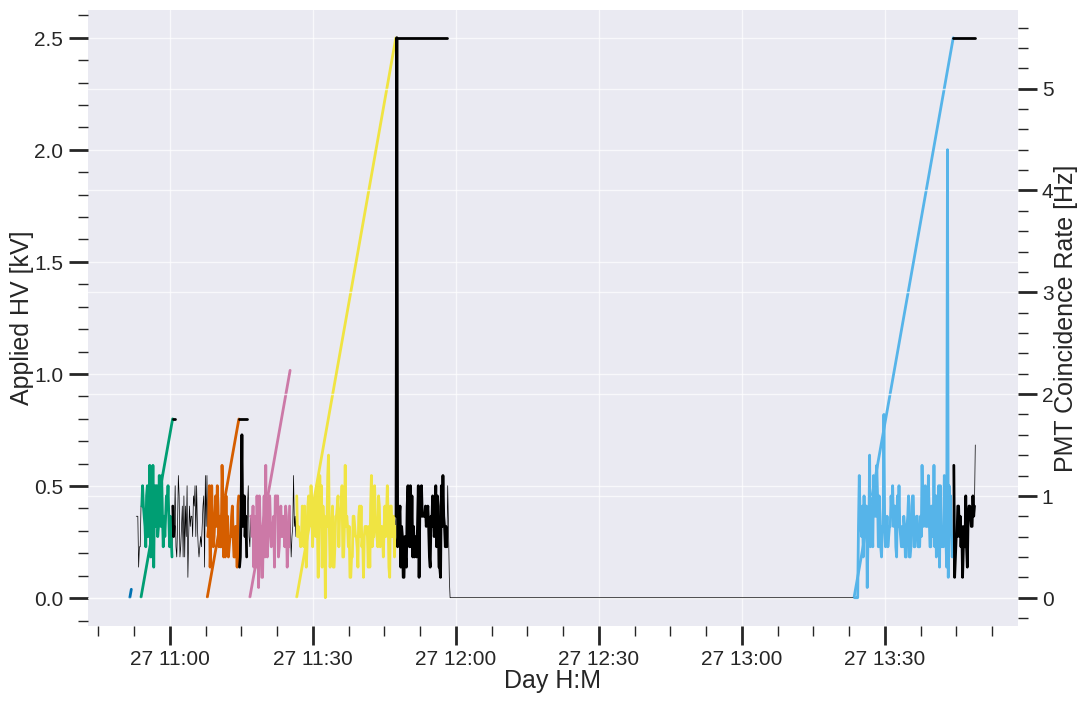

In [5]:
fig, ax = plt.subplots()
for ramp in ds.ramps:
    ax.plot(ramp["t"], ramp["v_app"])
    
for ramp in ds.flat_tops:
    ax.plot(ramp["t"], ramp["v_app"], 'k')
    
ax2 = ax.twinx()
ax2.plot(pmt_times, rates, linewidth=0.5, color='k')
for ramp in ds.ramps:
    ax2.plot(ramp["pmt_times"], ramp["pmt_rates"])
    
for ramp in ds.flat_tops:
    ax2.plot(ramp["pmt_times"], ramp["pmt_rates"], 'k')
    
ax2.set_ylabel("PMT Coincidence Rate [Hz]")
ax.set_ylabel("Applied HV [kV]")
ax.set_xlabel("Day H:M")
plt.show()

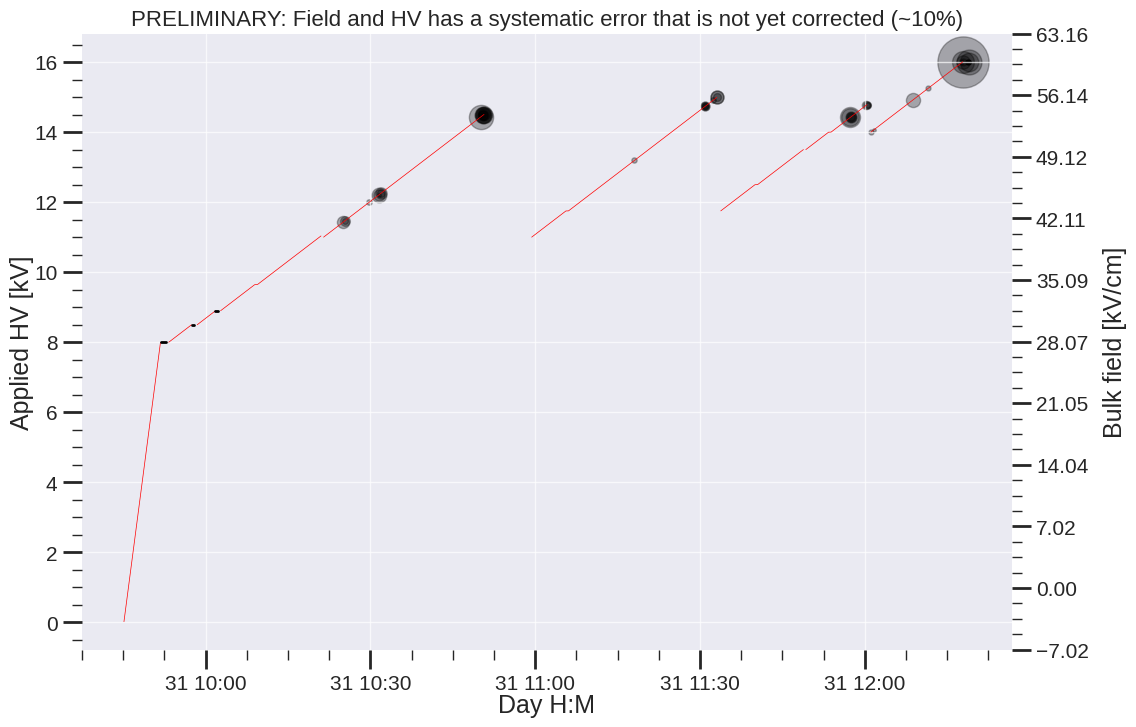

In [24]:
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
fig, ax = plt.subplots()



for ramp in ds.ramps:
    ax.plot(ramp["t"], ramp["v_app"], color='r', linewidth=0.5)
    
for ramp in ds.flat_tops:
    ax.plot(ramp["t"], ramp["v_app"], 'k')
    

    
#datetime input "dt" to dataset
#will find closest HV applied at that time. 
#Performs some corrections for when the nearest
#HV log point is farther than 2 seconds
def get_hv_at_time(ds, dt):    
    out_of_bounds = 2 #seconds to perform a different alg to determine HV log points. 
    #find index of closest time in self.ramp_data["t"]
    cl_idx = min(range(len(ds.ramp_data["t"])), key=lambda i: abs((ds.ramp_data["t"][i] - dt).total_seconds()))
    delta = (ds.ramp_data["t"][cl_idx] - dt).total_seconds() #number of seconds off from this logged HV time. 
    if(delta < out_of_bounds):
        return ds.ramp_data["v_app"][cl_idx] #kV #consider linearly interpolating in the future
    else:
        print("Desired time is out of bounds in get_hv_at_time! Consider writing this portion of code")
        return ds.ramp_data["v_app"][cl_idx]
    

#get any charge events above 2 mV
amp_th = 2
events = [] #{"time": datetime, "amp": mV, "hv": kV con}
for f in ds.ad2_files:
    df, date = pickle.load(open(f, "rb")) #opens the pandas dataframe object in the pickle file
    for evidx, row in df.iterrows():
        ch1 = row["Data"][0]
        dT = row["dT"]
        if(np.max(ch1) > amp_th):
            evt_time = datetime.datetime.fromtimestamp(row["Seconds"])
            amp = np.max(ch1)
            kv = get_hv_at_time(ds, evt_time)
            events.append({"time":evt_time, "amp":amp, "hv":kv})

for ev in events:
    ax.scatter(ev["time"], ev["hv"], s=5*(ev["amp"])**2, color='k', alpha=0.3)


gap = 0.285 #cm
axe = ax.twinx()
axe.set_yticks(np.array(ax.get_yticks())/gap)
axe.set_ylabel('Bulk field [kV/cm]', labelpad=10)
axe.grid(False)

ax.set_ylabel("Applied HV [kV]")
ax.set_xlabel("Day H:M")
ax.set_title("PRELIMINARY: Field and HV has a systematic error that is not yet corrected (~10%)")
plt.show()

no ramp file present at /p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run7/cosmics-endofrun/ramp.txt, leaving it empty
no g-events-file present at /p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run7/cosmics-endofrun/g_events.txt, leaving it empty
No ramp data in this dataset
Problem! Found no AD2 files with prefix 'prereduced*.p' in /p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run7/cosmics-endofrun/
Desired time is out of bounds in get_hv_at_time! Consider writing this portion of code
Problem! Found no AD2 files with prefix 'prereduced*.p' in /p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run7/ds06/
Problem! Found no AD2 files with prefix 'prereduced*.p' in /p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run7/ds11/
Problem! Found no Struck data files with prefix 'prereduced*.p' in /p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run7/ds11/struck/
no ramp file present at /p/lustre2/nexouser/d

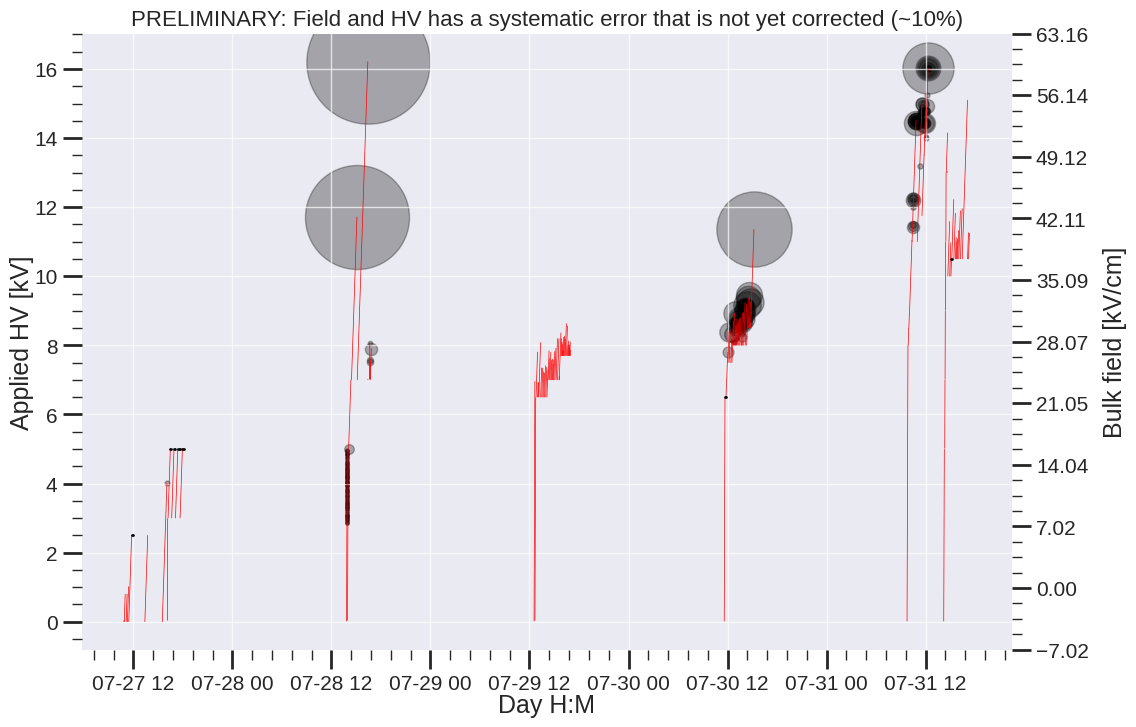

In [5]:
#an attempt to make code that will give me the HV ramp curve along with
#amplitudes and times of any charge  signals that arrive
fig, ax = plt.subplots()


for ds_single in datasets:
    ds = Dataset.Dataset(topdir+ds_single, config)
    
    #catch problems with data prereduction
    if(ds.ramp_data == {}):
        continue
    
    for ramp in ds.ramps:
        ax.plot(ramp["t"], ramp["v_app"], color='r', linewidth=0.5)

    for ramp in ds.flat_tops:
        ax.plot(ramp["t"], ramp["v_app"], 'k')



    #datetime input "dt" to dataset
    #will find closest HV applied at that time. 
    #Performs some corrections for when the nearest
    #HV log point is farther than 2 seconds
    def get_hv_at_time(ds, dt):    
        out_of_bounds = 2 #seconds to perform a different alg to determine HV log points. 
        #find index of closest time in self.ramp_data["t"]
        cl_idx = min(range(len(ds.ramp_data["t"])), key=lambda i: abs((ds.ramp_data["t"][i] - dt).total_seconds()))
        delta = (ds.ramp_data["t"][cl_idx] - dt).total_seconds() #number of seconds off from this logged HV time. 
        if(delta < out_of_bounds):
            return ds.ramp_data["v_app"][cl_idx] #kV #consider linearly interpolating in the future
        else:
            print("Desired time is out of bounds in get_hv_at_time! Consider writing this portion of code")
            return ds.ramp_data["v_app"][cl_idx]


    #get any charge events above 2 mV
    amp_th = 2
    events = [] #{"time": datetime, "amp": mV, "hv": kV con}
    for f in ds.ad2_files:
        df, date = pickle.load(open(f, "rb")) #opens the pandas dataframe object in the pickle file
        for evidx, row in df.iterrows():
            ch1 = row["Data"][0]
            dT = row["dT"]
            if(np.max(ch1) > amp_th):
                evt_time = datetime.datetime.fromtimestamp(row["Seconds"])
                amp = np.max(ch1)
                kv = get_hv_at_time(ds, evt_time)
                events.append({"time":evt_time, "amp":amp, "hv":kv})

    for ev in events:
        ax.scatter(ev["time"], ev["hv"], s=5*(ev["amp"])**2, color='k', alpha=0.3)


gap = 0.285 #cm
axe = ax.twinx()
axe.set_yticks(np.array(ax.get_yticks())/gap)
axe.set_ylabel('Bulk field [kV/cm]', labelpad=10)
axe.grid(False)

ax.set_ylabel("Applied HV [kV]")
ax.set_xlabel("Day H:M")
ax.set_title("PRELIMINARY: Field and HV has a systematic error that is not yet corrected (~10%)")
plt.show()